# Detecção de Fraudes com Cartão de Crédito usando Random Forest

Este notebook tem como objetivo desenvolver e avaliar um modelo de **machine learning** para detecção de fraudes em transações com cartão de crédito, utilizando o conjunto de dados disponível no Kaggle.

O processo inclui:

- Leitura e pré-processamento do dataset
- Normalização dos dados com `StandardScaler`
- Aplicação de **undersampling** para tratar o desbalanceamento das classes
- Treinamento de um modelo `RandomForestClassifier`
- Avaliação do modelo com métricas como *AUC-ROC*, *precision*, *recall*, *f1-score*
- Ajuste manual do threshold de decisão baseado na curva *Precision-Recall*
- Visualizações para suporte à tomada de decisão

# Objetivo
Numa situação ideal o modelo deveria ser capaz de detectar sempre uma transação fraudulenta, como isso é praticamente impossível devemos focar nossos esforços em diminuir os danos para o banco e os clientes.

![image.png](./../imgs/FraudDetectionSystem.jpg)

O pipeline utilizado pelos bancos para verificar se uma transação é fraudulenta ou não é o seguinte:
1. Transação é feita no terminal, ele verifica se o pin está correto se há saldo disponível entre outras checagens. Caso esteja tudo ok ele passa para a próxima etapa.
2. A requisição de transação é verificada pelas regras de bloqueio do banco que podem ser variáveis. Basicamente consistem em bloqueios de condições determinada como a quantidade de transações iguais na última hora ou verificação de país com hora de cada transação para detectar anormalidades.
3. A transação é aprovada caso passe da etapa anterior e agora inicia-se a checagem pós-aprovação que consiste em verificar regras de pontuação de fraude determinadas pelo banco e um modelo baseado em dados para uma detecção mais elaborada.
4. Caso esses dois modelos detectem anormalidades, os investigadores analisam manualmente a transação para verificar se é realmente uma fraude ou não.

O modelo deve auxiliar os humanos na detecção de fraudes, uma vez que é praticamente impossível para uma pessoa detectar padrões de comportamento de dados. Então devemos evitar que muitos falsos positivos sejam detectados a fim de não sobrecarregar os investigadores e gerar inconveniências para os clientes, mas também evitar que falsos negativos sejam detectados pois pode gerar prejuízos imensuráveis para o banco.

Olhando deste modo, é muito importante que o modelo detecte o máximo possível de verdadeiros positivos no qual será o foco desta pesquisa.


# Informações sobre o dataset
[Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)
- 284,807 registros de transações
- 492 registros marcados como fraude

O dataset é extremamente desbalanceado e será preciso ser feito um balanceamento do mesmo. Neste notebook será utilizando o método de Undersampling onde iremos documentar os resultados e comparar com outros métodos para selecionar o modelo mais preciso para a aplicação.

# Técnica de Undersampling
Consiste em remover instâncias da classe majoritária a fim de igualar sua quantidade com a classe minoritária. Neste caso usei a seleção aleatória de amostras, mas defini um valor de seed para manter os testes consistentes. Uma das vantagens do Undersampling é quando a precisão na deteção da classe minoritária é mais importante que a geral, mas este método pode levar a perda de dados importantes. Outra vantagem é que o conjunto de dados fica menor e sistemas com menos memória se beneficiam disso além de que o treinamento do modelo é bem mais rápido.

O conjunto foi dividido em 30% para teste e os outros 70% para treinamento. Utilizei o stratify para manter a proporção entre classes igual.

Foram selecionados em torno de 350 registros aleatórios da classe majoritária igualando assim com a quantidade da minoritária.

Os resultados podem ser vistos a seguir.

# Carregamento das bibliotecas e do dataset

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df = pd.read_csv("../../dataset/creditcard.csv", dtype=float)
print(df)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

# Separação das features e da variável alvo

In [3]:
X = df.drop(columns=["Time", "Class"])
y = df["Class"]
X = X[y.notna()]
y = y[y.notna()]

print(X)
# print(y)

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V20       V21  \
0       0.239599  0.098698  0.363787  0.090794  ...  0.25141

# Normalização do campo 'Amount'

In [4]:
scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X["Amount"].values.reshape(-1, 1))

print(X['Amount'])

0         0.244964
1        -0.342475
2         1.160686
3         0.140534
4        -0.073403
            ...   
284802   -0.350151
284803   -0.254117
284804   -0.081839
284805   -0.313249
284806    0.514355
Name: Amount, Length: 284807, dtype: float64


# Divisão de treino e teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Undersampling no treino

Utilizando undersampling ele reduz a classe maior para se igualar com a menor. Os registros da classe maior são selecionados de forma aleatória. Assim é feito o balanceamento utilizando undersampling.

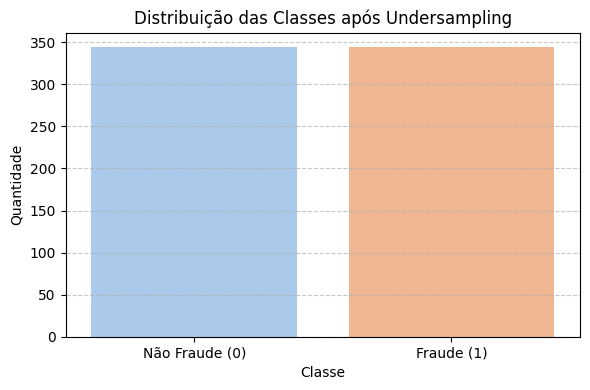

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

class_counts = y_train_resampled.value_counts().reset_index()
class_counts.columns = ['Classe', 'Quantidade']

plt.figure(figsize=(6, 4))
sns.barplot(data=class_counts, x='Classe', y='Quantidade', hue='Classe', palette='pastel', legend=False)

plt.title("Distribuição das Classes após Undersampling")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.xticks([0, 1], ["Não Fraude (0)", "Fraude (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Treinamento do modelo

In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

# Previsões de probabilidade do teste

In [8]:
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe 1

# Plotagem do precision recall curve

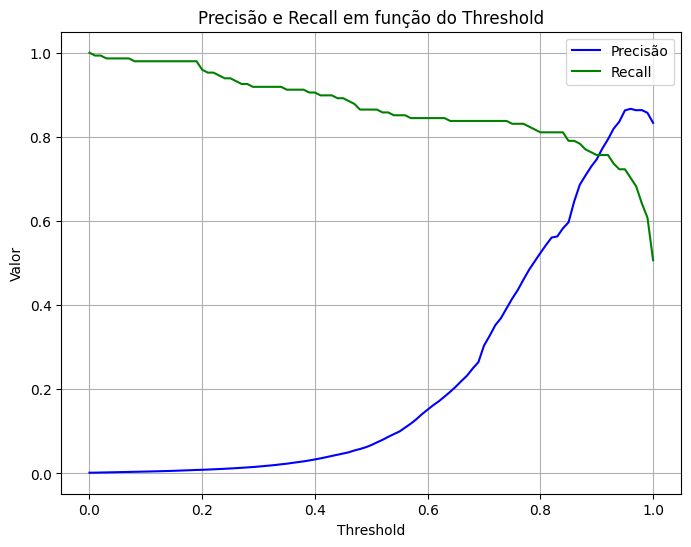

In [9]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precisão", color="b")
plt.plot(thresholds, recall[:-1], label="Recall", color="g")
plt.xlabel("Threshold")
plt.ylabel("Valor")
plt.title("Precisão e Recall em função do Threshold")
plt.legend()
plt.grid()
plt.show()

# Definição de um threshold

In [10]:
THRESHOLD = 0.94
y_pred_adjusted = (y_proba >= THRESHOLD).astype(int)

# Avaliação

In [11]:
print("Relatório de Classificação (com threshold ajustado):")
print(classification_report(y_test, y_pred_adjusted))

print("Matriz de Confusão (com threshold ajustado):")
print(confusion_matrix(y_test, y_pred_adjusted))

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

Relatório de Classificação (com threshold ajustado):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85295
         1.0       0.84      0.72      0.78       148

    accuracy                           1.00     85443
   macro avg       0.92      0.86      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Matriz de Confusão (com threshold ajustado):
[[85274    21]
 [   41   107]]
AUC-ROC: 0.9732


Com um treshold de 0.94 o modelo apresenta uma precisão de 0.84, recall de 0.72 e um F1-score de 0.78 para todas as vezes que o modelo acertou se uma transação era uma fraude ou não.

# Referências
https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_2_Background/FDS.html